In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from ForecastSimulator import Forecastsimulator, forecast_split
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import date
from dateutil.relativedelta import relativedelta

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed, GRU
from tensorflow.keras.layers import MaxPooling1D, Flatten
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError
from pandas_datareader import data as web

plt.rcParams['figure.figsize'] = (18, 10)
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.grid'] = True

In [32]:
today = date.today()
start_date = today - relativedelta(years=4)

print(start_date)
data = pd.DataFrame(web.DataReader('btc.v', 'stooq', start_date))
data.info()

2019-03-18
<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Empty DataFrame


In [24]:
unicredit = data[['Close']]
unicredit = unicredit.sort_index(ascending = True)
unicredit

,Close
Date,
2019-03-18,2.033568
2019-03-19,2.028566
2019-03-20,2.024019
2019-03-21,2.014469
2019-03-22,2.050848
...,...
2023-03-13,2.326000
2023-03-14,2.403500
2023-03-15,2.238500


<Axes: xlabel='Date'>

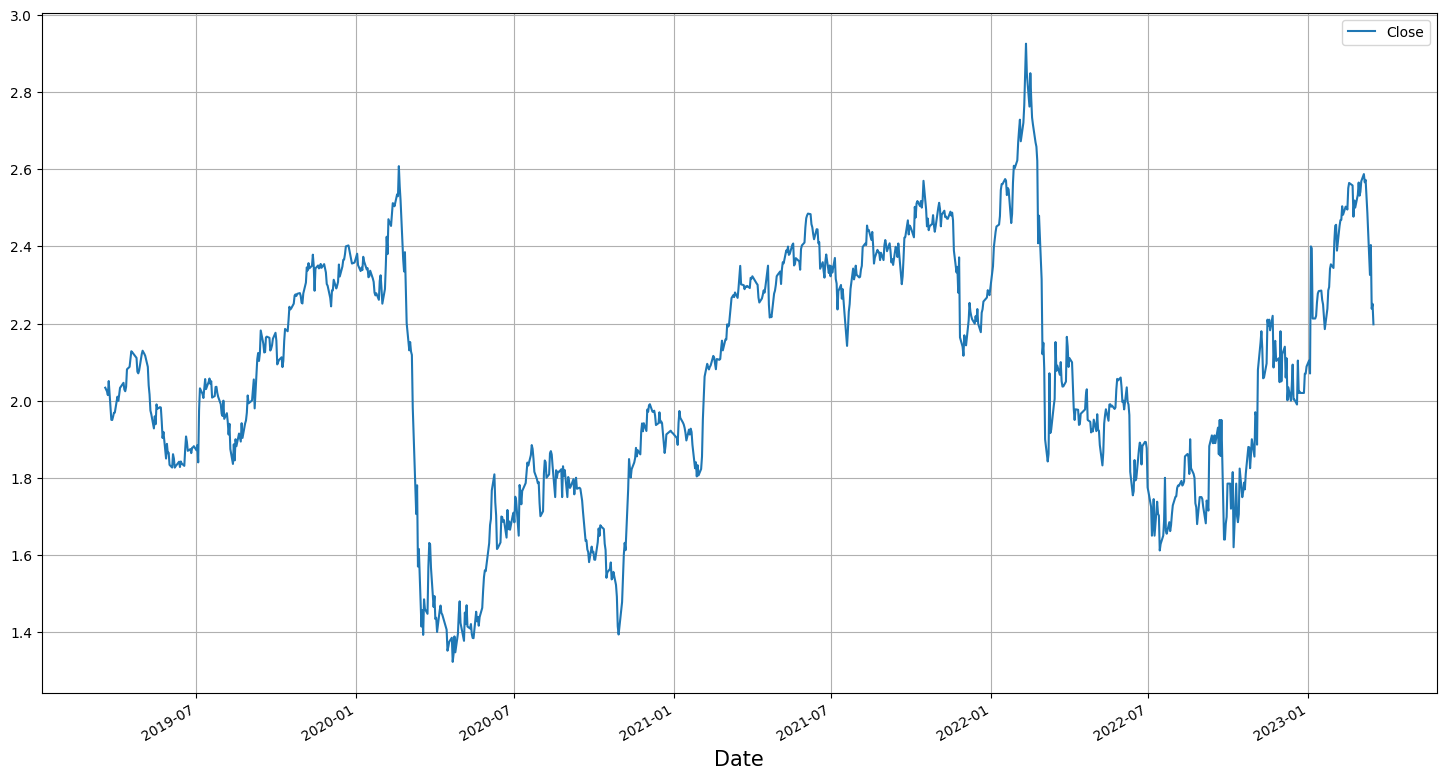

In [25]:
unicredit.plot()

In [26]:
def cnn_lstm(ws=30, dtp=1, multi=3):
    
    model = tf.keras.Sequential()

    # Creating the Neural Network model
    # CNN layers
    model.add(TimeDistributed(Conv1D(256, kernel_size=5, padding='same', activation='selu', input_shape=(None, ws, 1))))
    model.add(TimeDistributed(MaxPooling1D(2)))
    model.add(TimeDistributed(Flatten()))
    model.add(Dense(5, kernel_regularizer=L2(0.3)))

    # LSTM layers
    model.add(Bidirectional(LSTM(multi*ws*2, return_sequences=True)))
    model.add(Dense(5, kernel_regularizer=L2(0.3)))
    model.add(Bidirectional(LSTM(multi*ws*2, return_sequences=False)))
    model.add(Dense(5, kernel_regularizer=L2(0.3)))

    #Final layers
    model.add(Dense(dtp, activation='linear'))
    model.compile(optimizer='Adamax', loss='mse', metrics=['mse', 'mae', 'mape'])

    return model

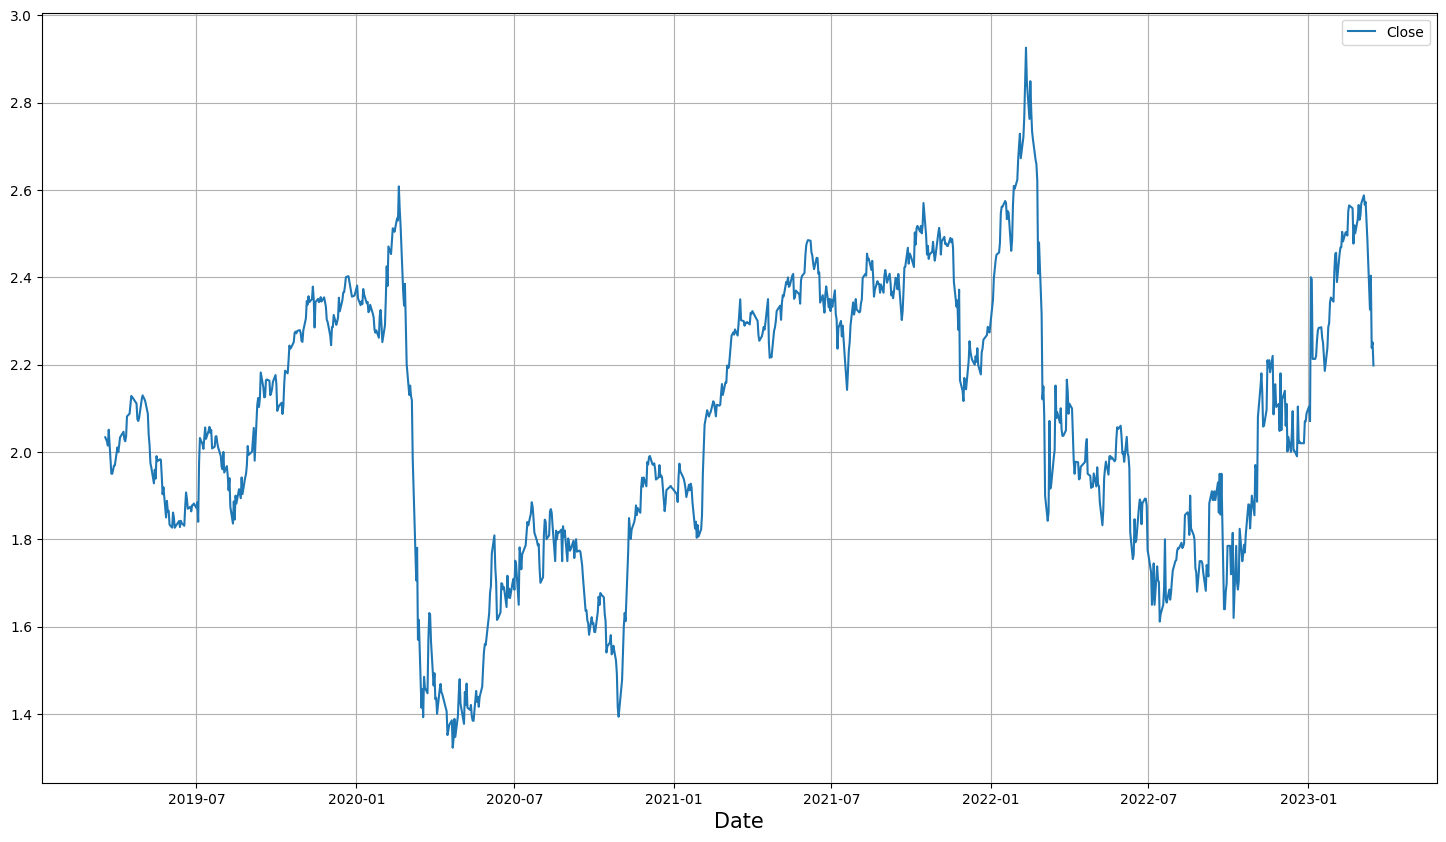

Epoch 1/50
16/16 - 7s - loss: 7.9685 - mse: 0.9734 - mae: 0.8326 - mape: 101.1237 - 7s/epoch - 430ms/step
Epoch 2/50
16/16 - 0s - loss: 5.2057 - mse: 0.7755 - mae: 0.7378 - mape: 92.2248 - 271ms/epoch - 17ms/step
Epoch 3/50
16/16 - 0s - loss: 3.5144 - mse: 0.3707 - mae: 0.4794 - mape: 90.3865 - 280ms/epoch - 18ms/step
Epoch 4/50
16/16 - 0s - loss: 2.5152 - mse: 0.1816 - mae: 0.3081 - mape: 85.3076 - 280ms/epoch - 18ms/step
Epoch 5/50
16/16 - 0s - loss: 1.9015 - mse: 0.1463 - mae: 0.2674 - mape: 70.6623 - 272ms/epoch - 17ms/step
Epoch 6/50
16/16 - 0s - loss: 1.4847 - mse: 0.1214 - mae: 0.2387 - mape: 66.8565 - 272ms/epoch - 17ms/step
Epoch 7/50
16/16 - 0s - loss: 1.1796 - mse: 0.1116 - mae: 0.2295 - mape: 64.6504 - 272ms/epoch - 17ms/step
Epoch 8/50
16/16 - 0s - loss: 0.9551 - mse: 0.1025 - mae: 0.2165 - mape: 66.9557 - 272ms/epoch - 17ms/step
Epoch 9/50
16/16 - 0s - loss: 0.7865 - mse: 0.1002 - mae: 0.2136 - mape: 63.5057 - 272ms/epoch - 17ms/step
Epoch 10/50
16/16 - 0s - loss: 0.6606 

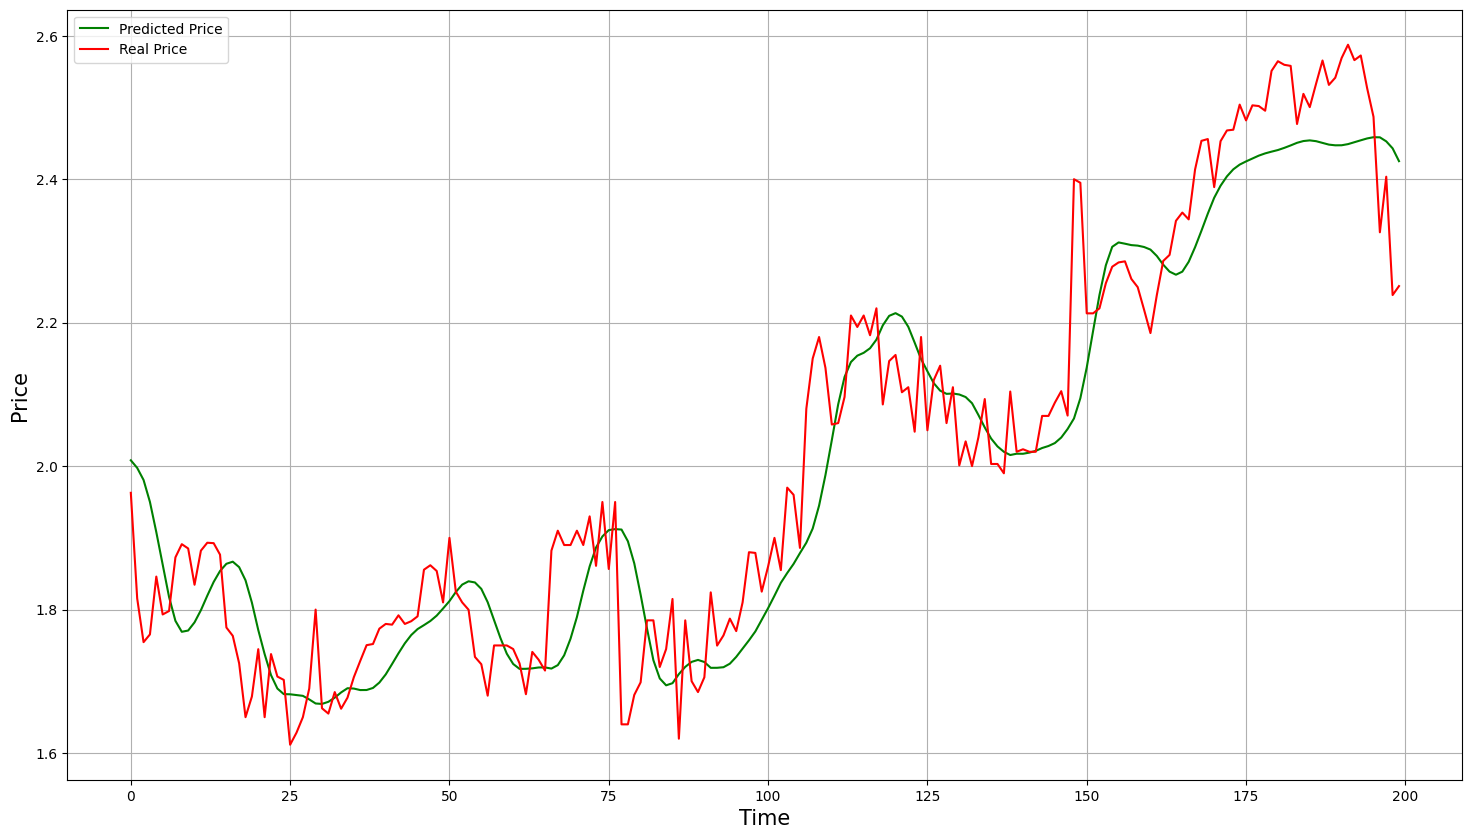

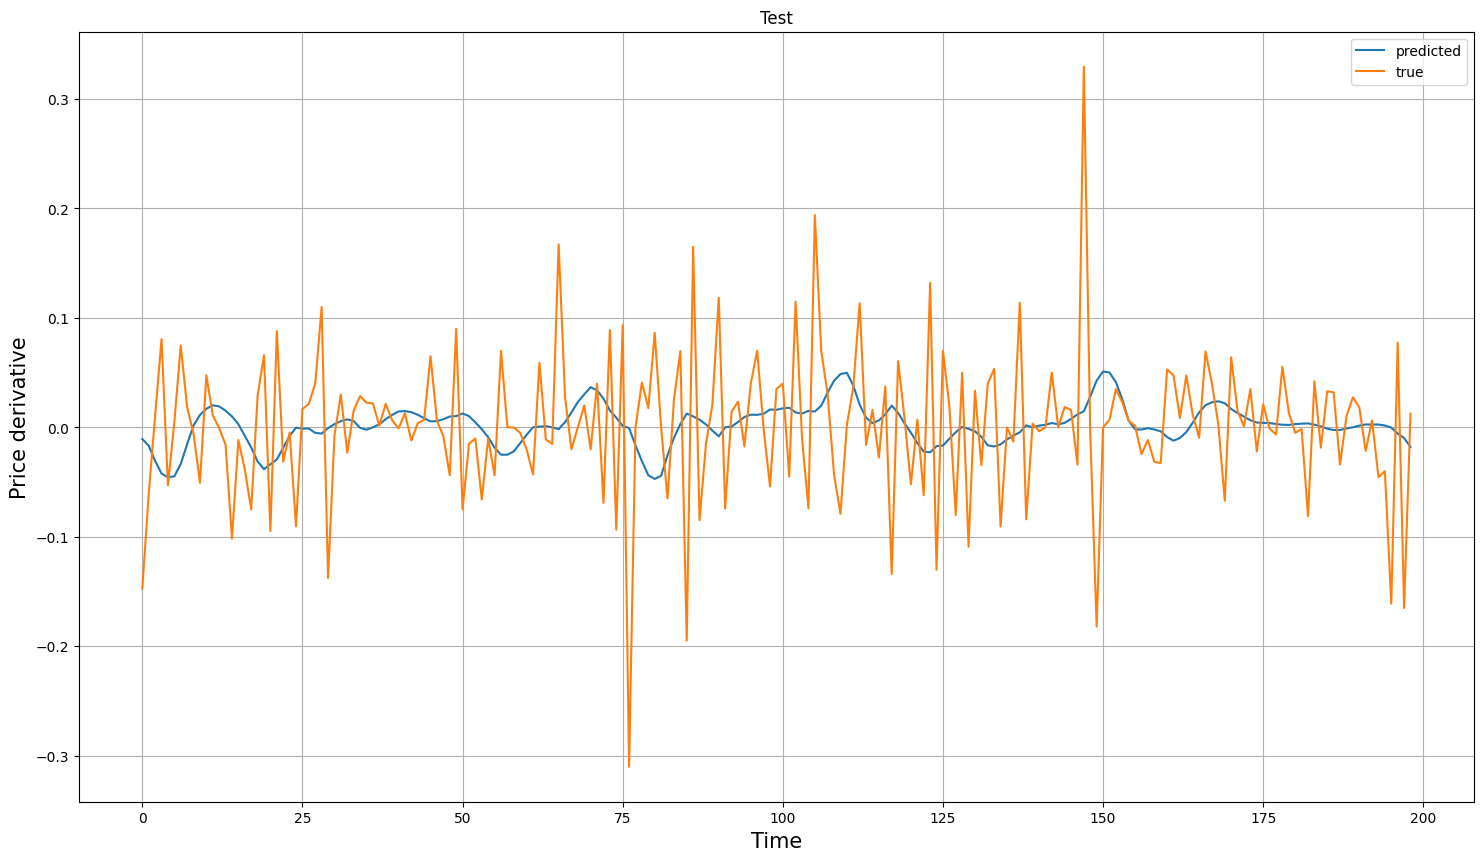

0.5


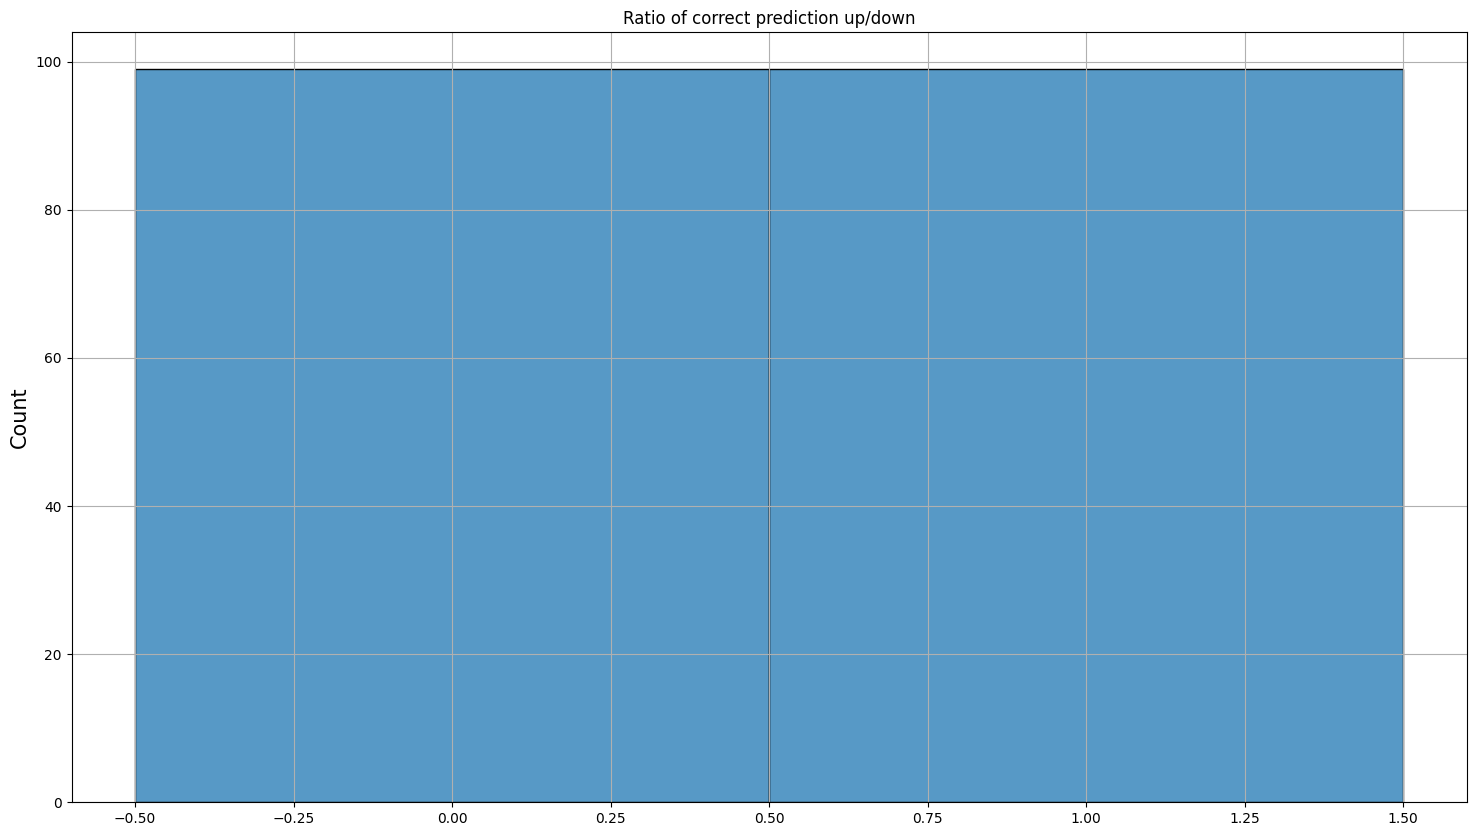

0.22502107551025058 3.482785010928389


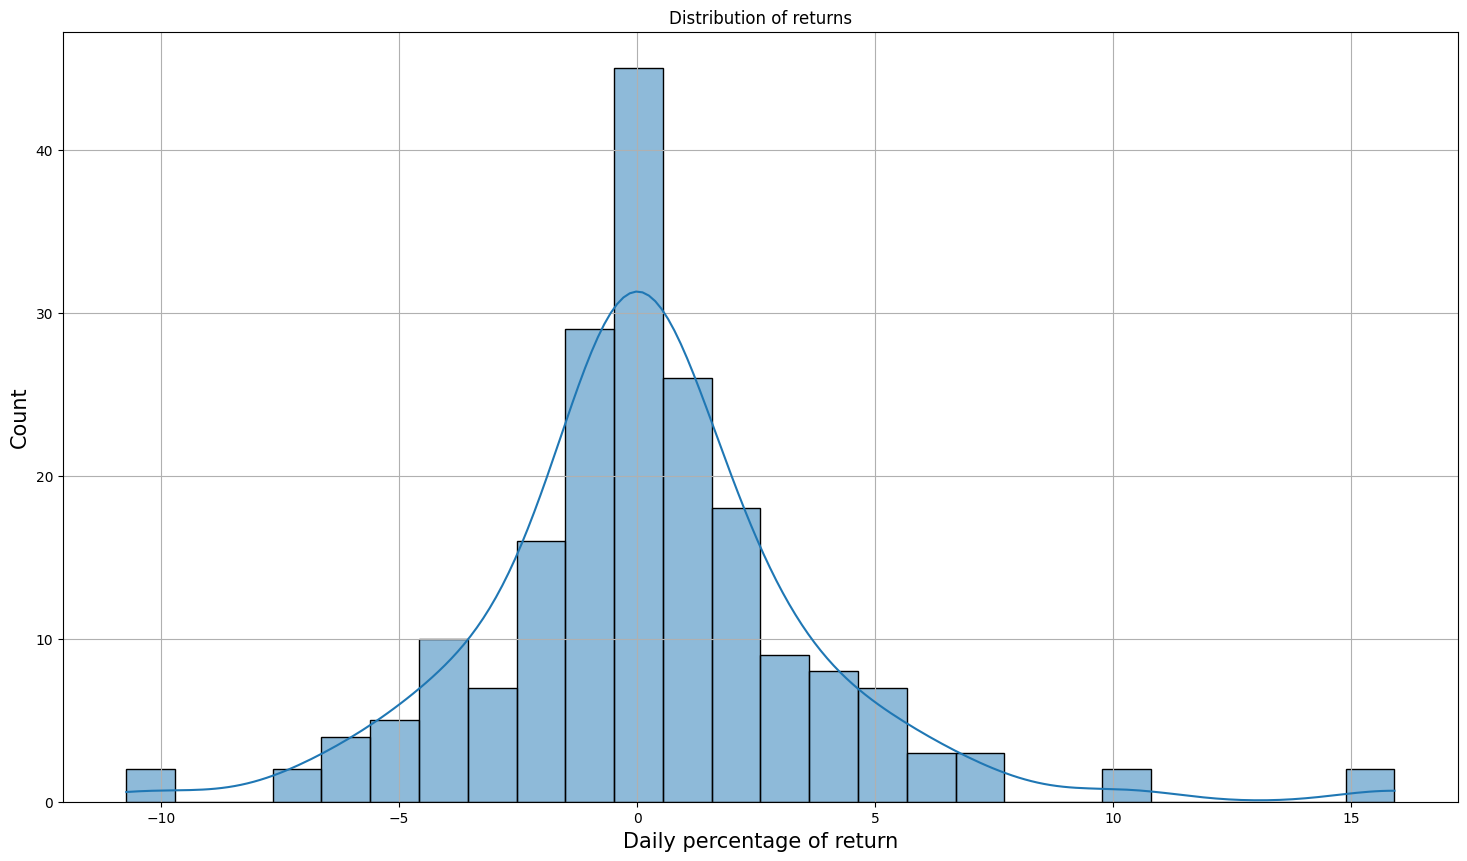

89.10834590205923


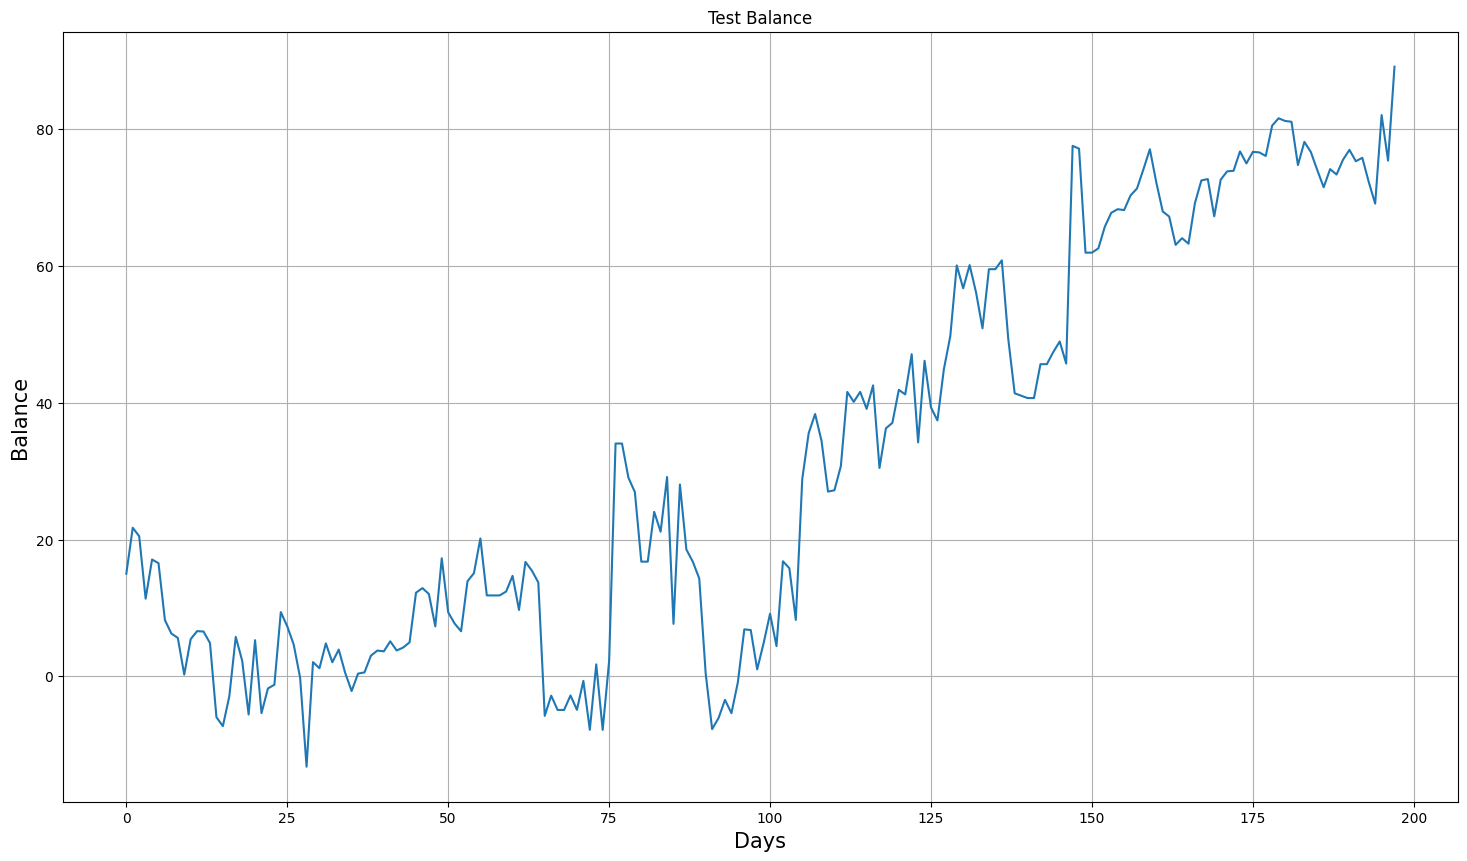

In [33]:
ws = 20
dtp = 1
sns.lineplot(unicredit)
plt.show()

X_train, X_test, y_train, y_test = forecast_split(unicredit, window_size=ws, dtp=dtp, test_days=200)
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0],1,ws,1)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0],1,ws,1)
    
fs = Forecastsimulator(cnn_lstm(ws=ws, dtp=dtp, multi=3))
fs.train_nn(X_train_reshaped, y_train_scaled, epochs=50, batch_size=50)
prediction = scaler_y.inverse_transform(fs.predict(X_test_reshaped))

fs.plot_prediction(prediction, y_test)
fs.simulate(prediction, y_test)
del fs